# Lens model DESIJ0923+1829

Author: Mamunur Rashid

acknowledgement: Robin, Tanver

# import of standard python libraries


In [1]:
import h5py
import matplotlib.pyplot as plt
import joblib
import corner
import copy

# import of standard python libraries
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util, param_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

# importing Data

### Extracting the observed image data from a .h5 file

In [ ]:
with h5py.File("DESIJ0923+1829_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
#kwargs_data

### Extracting the information about Point Spread Function(PSF) from a .h5 file

In [ ]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"
# kwargs_psf

# Visualizing the image

/tmp/ipykernel_13047/4250926759.py:6: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


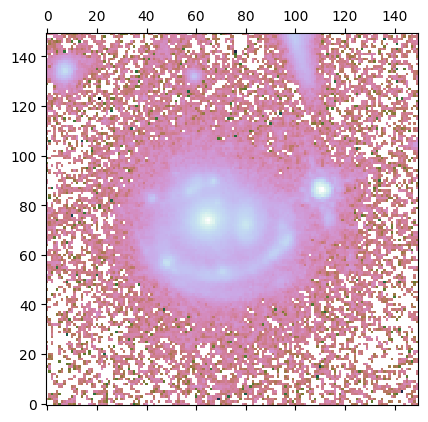

In [ ]:
image_data = kwargs_data["image_data"]

#replace_negatives = np.vectorize(lambda x: 0 if x < 0 else x)
#image_data = replace_negatives(image_data)

plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
# plt.grid(which='both', color='black')
# plt.minorticks_on()
# plt.grid(which='minor', color='black')
#image_data

#plt.show()

# Masking

## coordinate setup

In [ ]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)


## Masking regions

/tmp/ipykernel_13047/468074870.py:182: RuntimeWarning: invalid value encountered in log10
  axs[0].matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
/tmp/ipykernel_13047/468074870.py:183: RuntimeWarning: divide by zero encountered in log10
  axs[1].matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
/tmp/ipykernel_13047/468074870.py:183: RuntimeWarning: invalid value encountered in log10
  axs[1].matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


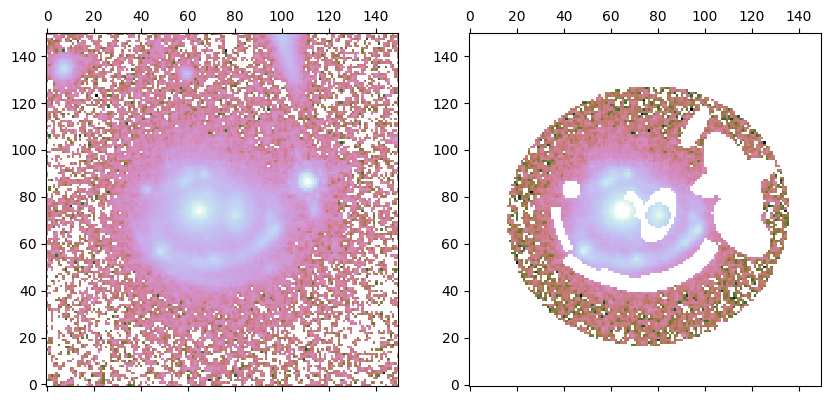

In [ ]:

r = 4.8  # arcseconds
b = 4.4
lens_center_ra = 0
lens_center_dec = 0

# outlinig the lens system
mask_outer = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0,
    lens_center_dec - 0.3,
    r,
    b,
    0.95*np.pi,
)


# big object at 2 o'clock
mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec + 1.0,
    1.7,
    0.75,
    1.1,
)
# horizonal ray of big object at 2 o'clock
mask_ext_1_x = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec + 1.0,
    1.5,
    0.5,
    -0.3,
)

# 10 o'clock near arc
mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 2.59,
    lens_center_dec + 0.6,
    0.3,
    0.3,
    1.1,
)

# second arc, at 8 o'clock
mask_ext_arc_1 = mask_util.mask_half_moon(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.3 -0.5,
    lens_center_dec + 0.3,
    2.6,
    3.0,
    np.pi,
    np.pi/2
)
# second arc, at 5 o'clock
mask_ext_arc_2 = mask_util.mask_half_moon(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.2,
    lens_center_dec + 0.2,
    2.5,
    3.08,
    -np.pi,
    np.pi/1.5,
)
# second arc, at 6 o'clock
mask_ext_arc_3 = mask_util.mask_half_moon(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.2,
    lens_center_dec + 0.2,
    2.6,
    3.08,
    3,
    np.pi/4
)
# second arc, at 7 o'clock
mask_ext_arc_4 = mask_util.mask_half_moon(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.2,
    lens_center_dec + 0.2,
    2.8,
    3.1,
    1.9,
    np.pi/6
)

# main lense ellipse
mask_main = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.84,
    lens_center_dec - 0.12,
    0.2,
    0.2,
    0
)

# main lense, not to mask center
mask_main_cen = mask_util.mask_half_moon(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.84,
    lens_center_dec - 0.15,
    0.42,
    0.75,
    -np.pi/3,
    np.pi/1.75
)


# satellite ellipse
mask_sat_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.36, #0.45,
    lens_center_dec - 0.28, #0.2,
    0.55,
    1.0,
    np.pi/8
)

# satellite not to mask center
mask_sat_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.36,
    lens_center_dec - 0.28,
    0.41,
    0.41,
    0
)

mask_out_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.18,
    lens_center_dec - 0.7,
    1.2,
    0.7,
    np.pi/4
)

mask_out_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 1.6,
    lens_center_dec + 2.7,
    0.8,
    0.3,
    np.pi/1.5
)

mask = (mask_outer) *  \
    (1 - mask_ext_1) * \
    (1 - mask_ext_1_x) * \
    (1 - mask_ext_2) * \
    (1-mask_ext_arc_1) * \
    (1-mask_ext_arc_2) * \
    (1-mask_ext_arc_3)  * \
    (1-mask_ext_arc_4) * \
    (1-(mask_sat_1 - mask_sat_2)) * \
    (1-mask_main_cen)*(1-mask_main) * \
    (1- mask_out_5)*(1-mask_out_1)



mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)
masked_image_data = np.multiply(image_data, mask)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
axs[1].matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
plt.show()

# Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{q x^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

## Adding profiles

In [ ]:
lens_model_list = ["EPL", "SHEAR", "SIE"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

## lens model (mass)

In [ ]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

### EPL profile (lens)

In [ ]:
lens_center_x = 0.84
lens_center_y = -0.12


fixed_lens.append({})
kwargs_lens_init.append(
    {
        'theta_E': 1.3962, 
        'gamma': 2.1853, 
        'e1': -0.0200, 
        'e2': 0.0195, 
        'center_x': 0.8393, 
        'center_y': -0.0593
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.1,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": 0.1,
        "center_y": 0.1,
        "gamma": 0.05
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": lens_center_x - 2.5 ,
        "center_y": lens_center_y - 2.5,
        "gamma": 1.5
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 3.5,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": lens_center_x + 2.5,
        "center_y": lens_center_y + 2.5,
        "gamma": 2.3
    }
)

### SHEAR profile (lens)

In [ ]:
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({
    'gamma1': 0.1070, 
    'gamma2': -0.0462
    })
kwargs_lens_sigma.append({"gamma1": 0.05, "gamma2": 0.05})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})

### SIE profile (satelite lens)

In [ ]:
satellite_center_x = -0.36
satellite_center_y = -0.28
satellite_centroid_bound = 1


fixed_lens.append({})
kwargs_lens_init.append(
    {
        'theta_E': 0.4613, 
        'e1': -0.1449, 
        'e2': -0.0778, 
        'center_x': -0.3851, 
        'center_y': -0.2554
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": satellite_centroid_bound / 5,
        "center_y": satellite_centroid_bound / 5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.15,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": satellite_center_x - 0.5,
        "center_y": satellite_center_y - 0.5,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 1.5,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": satellite_center_x + 0.5,
        "center_y": satellite_center_y + 0.5,
    }
)

## lens light model

In [ ]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

### SERSIC (satelite lens)

In [ ]:
fixed_lens_light.append({"n_sersic": 1.0})
kwargs_lens_light_init.append(
    {
        'amp': 153.04393152160245, 
        'R_sersic': 0.2669, 
        'e1': -0.1449, 
        'e2': -0.0778, 
        'center_x': -0.3851, 
        'center_y': -0.2554
    }
)
kwargs_lens_light_sigma.append(
    {
        "R_sersic": 0.1,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 0.1
    }
)
kwargs_lower_lens_light.append(
    {
        "R_sersic": 0.15,
        "e1": -0.5,
        "e2": -0.5,
        'center_x': satellite_center_x - 0.5, 
        'center_y': satellite_center_y - 0.5,
        "amp": -2
    }
)
kwargs_upper_lens_light.append(
    {
        "R_sersic": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        'center_x': satellite_center_x + 0.5, 
        'center_y': satellite_center_y + 0.5,
        "amp": 5
    }
)

### SERSIC main galaxy

In [ ]:
fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        'amp': 138.23052321308612, 
        'R_sersic': 0.5538,  
        'e1': 0.0043, 
        'e2': -0.0049, 
        'center_x': 0.8497, 
        'center_y': -0.1086
    }
)
kwargs_lens_light_sigma.append(
    {
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 0.1,
    }
)
kwargs_lower_lens_light.append(
    {
        "R_sersic": 0.01,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": lens_center_x-1.0,
        "center_y": lens_center_y-1.0,
        "amp": -2,
    }
)
kwargs_upper_lens_light.append(
    {
        "R_sersic": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": lens_center_x + 1.0,
        "center_y": lens_center_y + 1.0,
        "amp": 5,
    }
)


## source galaxy

In [ ]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

### 1st SERSIC

In [ ]:
fixed_source.append({'n_sersic': 1})
kwargs_source_init.append(
    {
        'amp': 113.22384973096803, 
        'R_sersic': 0.1926, 
        'e1': 0.2012, 
        'e2': 0.0497, 
        'center_x': 0.3694, 
        'center_y': -0.4074
    }
)
kwargs_source_sigma.append(
    {
        "R_sersic": 0.1,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 0.1,
    }
)
kwargs_lower_source.append(
    {
        "R_sersic": 0.01,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -1.5,
        "center_y": -1.5,
        "amp": -2,
    }
)
kwargs_upper_source.append(
    {
        "R_sersic": 0.25,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 1.5,
        "center_y": 1.5,
        "amp": 5,
    }
)

### SHAPELET profile

In [ ]:
fixed_source.append({"n_max": 14})
kwargs_source_init.append({
    'beta': 0.0817, 
    'center_x': 0.4136962466154499, 
    'center_y': -0.4969184696820904})
kwargs_source_sigma.append({"beta": 0.01, "center_x": 0.1, "center_y": 0.1})
kwargs_lower_source.append({"beta": 0.01, "center_x": -1.5, "center_y": -1.5})
kwargs_upper_source.append({"beta": 0.12, "center_x": 1.5, "center_y": 1.5})

## parameter gathering

### Joint constraints

In [ ]:
joint_lens_with_light = [[0, 2, ["center_x", "center_y", "e1", "e2"]]]
joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]

### profile parameter gathering

In [ ]:
lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]
lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]
source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

### defining kwargs_param dict

In [ ]:
# Combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_with_light": joint_lens_with_light,
    "joint_source_with_source": joint_source_with_source,
}

### Numerical settings

In [ ]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 3, "supersampling_convolution": False}

### Combining all the information to be sent to lenstronomy

In [ ]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

# PSO run

In [ ]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["update_settings", {"lens_add_fixed": [[0, ["gamma"]]]}],
    ["PSO", {"sigma_scale": 1.0, "n_particles": 10, "n_iterations": 10,}],
    ["update_settings", {"lens_remove_fixed": [[0, ["gamma"]]]}],
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...


## joblib

In [ ]:
#kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ0923+1829_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## Visualizing the fitted model

-2.3806958386229273 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  2.3806958386235526


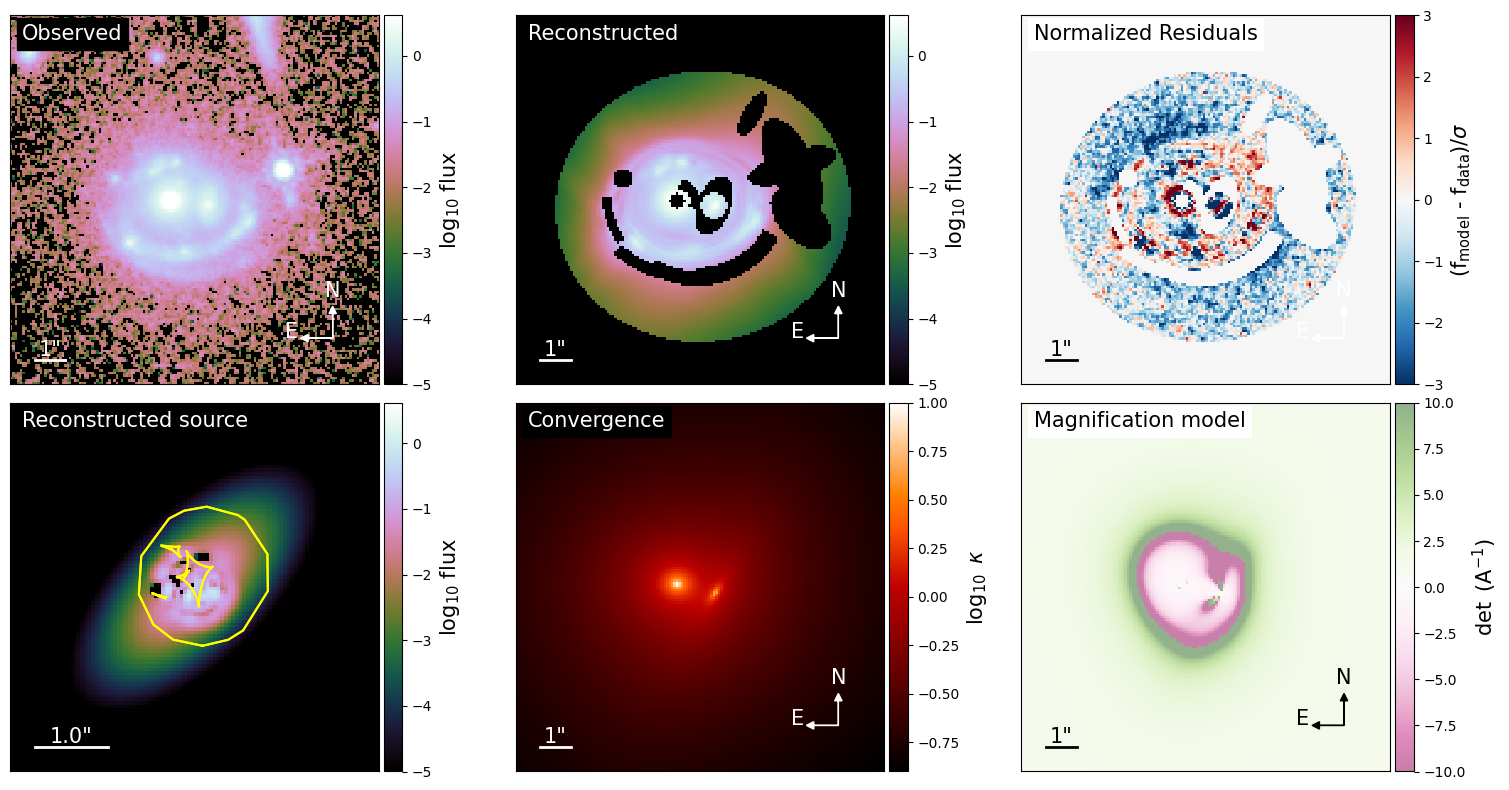

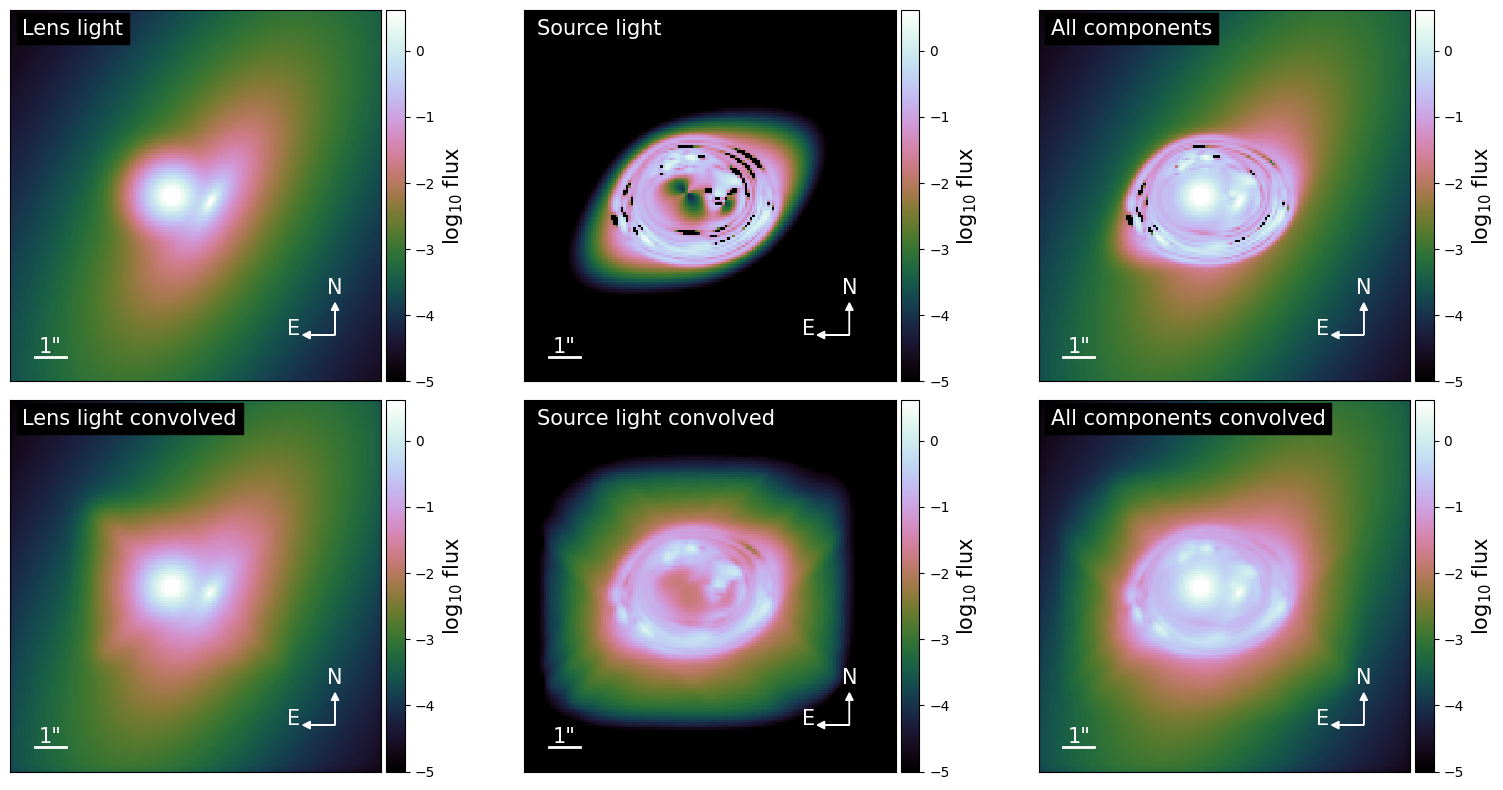

{'kwargs_lens': [{'theta_E': 1.38301513995028, 'gamma': 1.879, 'e1': 0.06139715607825226, 'e2': 0.017750358942845195, 'center_x': 0.8377295983487706, 'center_y': 0.005358720130545817}, {'gamma1': 0.11726237264057784, 'gamma2': -0.05046411362090343, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.3881674660791493, 'e1': -0.1835453594668396, 'e2': -0.35586568900018484, 'center_x': -0.39477770259688655, 'center_y': -0.29228570096102113}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.21492158028225125, 'n_sersic': 1, 'e1': 0.003160225524007621, 'e2': -0.36400465683077377, 'center_x': 0.4782537337164529, 'center_y': -0.24205446104757078}, {'amp': 1, 'n_max': 14, 'beta': 0.09855095558010613, 'center_x': 0.4782537337164529, 'center_y': -0.24205446104757078}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.49859125868213144, 'n_sersic': 4.0, 'e1': -0.1835453594668396, 'e2': -0.35586568900018484, 'center_x': -0.39477770259688655, 'center_y': -0.29228570096102113}, {'amp': 1, 'R_sersic': 0.35568863857627125

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(
    ax=axes[0, 2],
    v_min=-3,
    v_max=3,
    cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0],
    deltaPix_source=0.05,
    with_caustics=True,
    scale_size=1.0,
    numPix=100
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0,
    hspace=0.05
)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0,
    hspace=0.05
)
plt.show()
print(kwargs_result)

### MCMC

In [ ]:
mcmc_backend = "mcmc_backend.h5"

n_walkers = 100
n_step = 1
n_burn = 0


fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": n_burn,
            "n_run": n_step,
            "n_walkers": n_walkers,
            "sigma_scale": 0.1,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,
            "progress":True
        },
    ]
]

fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params
)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)

100%|██████████| 1000/1000 [7:40:44<00:00, 27.64s/it] 

Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  0
Sampling iterations (in current run): 1000
27675.950835227966 time taken for MCMC sampling


In [ ]:
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()

### Traceplot

(100000, 25)
N_step: 1000, N_walkers: 100, N_params: 25


theta_E_lens0 1.6120 ± 0.0020
gamma_lens0 1.8059 ± 0.0019
e1_lens0 -0.0241 ± 0.0016
e2_lens0 -0.0118 ± 0.0024
center_x_lens0 0.6585 ± 0.0014
center_y_lens0 0.1754 ± 0.0038
gamma1_lens1 0.0972 ± 0.0013
gamma2_lens1 -0.0803 ± 0.0014
theta_E_lens2 0.1532 ± 0.0020
R_sersic_source_light0 0.2449 ± 0.0014
e1_source_light0 -0.4863 ± 0.0054
e2_source_light0 -0.4889 ± 0.0045
center_x_source_light0 0.2970 ± 0.0024
center_y_source_light0 -0.2450 ± 0.0037
beta_source_light1 0.0571 ± 0.0003
R_sersic_lens_light0 0.4621 ± 0.0021
e1_lens_light0 0.0795 ± 0.0033
e2_lens_light0 -0.3825 ± 0.0069
center_x_lens_light0 -0.3706 ± 0.0039
center_y_lens_light0 -0.2924 ± 0.0038
R_sersic_lens_light1 0.7061 ± 0.0039
e1_lens_light1 0.1516 ± 0.0032
e2_lens_light1 -0.0026 ± 0.0016
center_x_lens_light1 0.7319 ± 0.0021
center_y_lens_light1 -0.0680 ± 0.0013


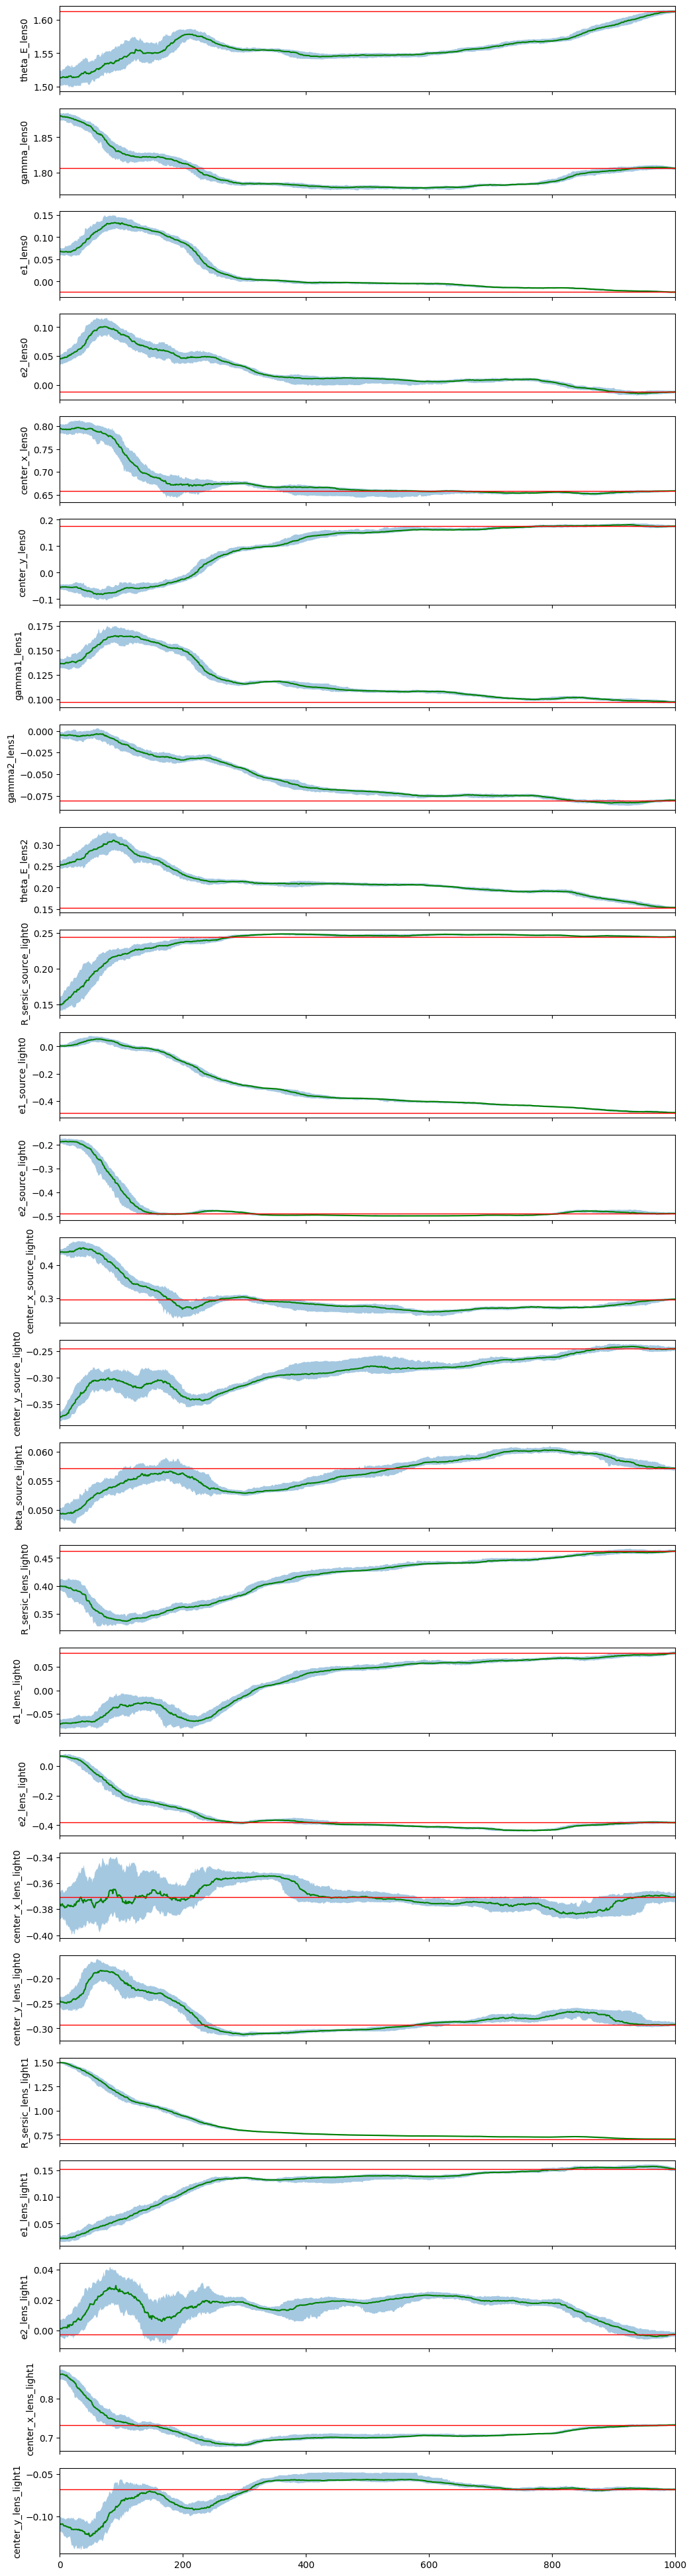

In [ ]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

print(samples_mcmc.shape)


n_params = samples_mcmc.shape[1]
n_walkers = 100
n_step = int(samples_mcmc.shape[0] / n_walkers)
n_burn = 0
print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))
chain = np.empty((n_walkers, n_step, n_params))
for i in range(n_params):
    samples = samples_mcmc[:, i]
    reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
    chain[:, :, i] = reshaped_samples
mean_pos = np.zeros((n_params, n_step))
median_pos = np.zeros((n_params, n_step))
std_pos = np.zeros((n_params, n_step))
q16_pos = np.zeros((n_params, n_step))
q84_pos = np.zeros((n_params, n_step))
for i in range(n_params):
    for j in range(n_step):
        mean_pos[i][j] = np.mean(chain[:, j, i])
        median_pos[i][j] = np.median(chain[:, j, i])
        std_pos[i][j] = np.std(chain[:, j, i])
        q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
        q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)
fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))
burnin = -1
last = n_step
medians = []
param_values = [
    median_pos[0][last - 1],
    (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
    median_pos[1][last - 1],
    (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
]
for i in range(n_params):
    print(
        param_mcmc[i],
        "{:.4f} ± {:.4f}".format(
            median_pos[i][last - 1],
            (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
        ),
    )
    ax[i].plot(median_pos[i][:last], c="g")
    ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
    ax[i].fill_between(
        np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
    )
    ax[i].set_ylabel(param_mcmc[i], fontsize=10)
    ax[i].set_xlim(0, last)
    medians.append(np.median(median_pos[i][burnin:last]))
if True:
    fig.set_size_inches((12.0, 2 * len(param_mcmc)))
    plt.show()

Number of non-linear parameters in the MCMC process: 25
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'theta_E_lens2', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1', 'center_x_lens_light1', 'center_y_lens_light1']
Number of evaluations in the MCMC process: 100000
100000
Shape of samples_mcmc_cut: (4000, 25)


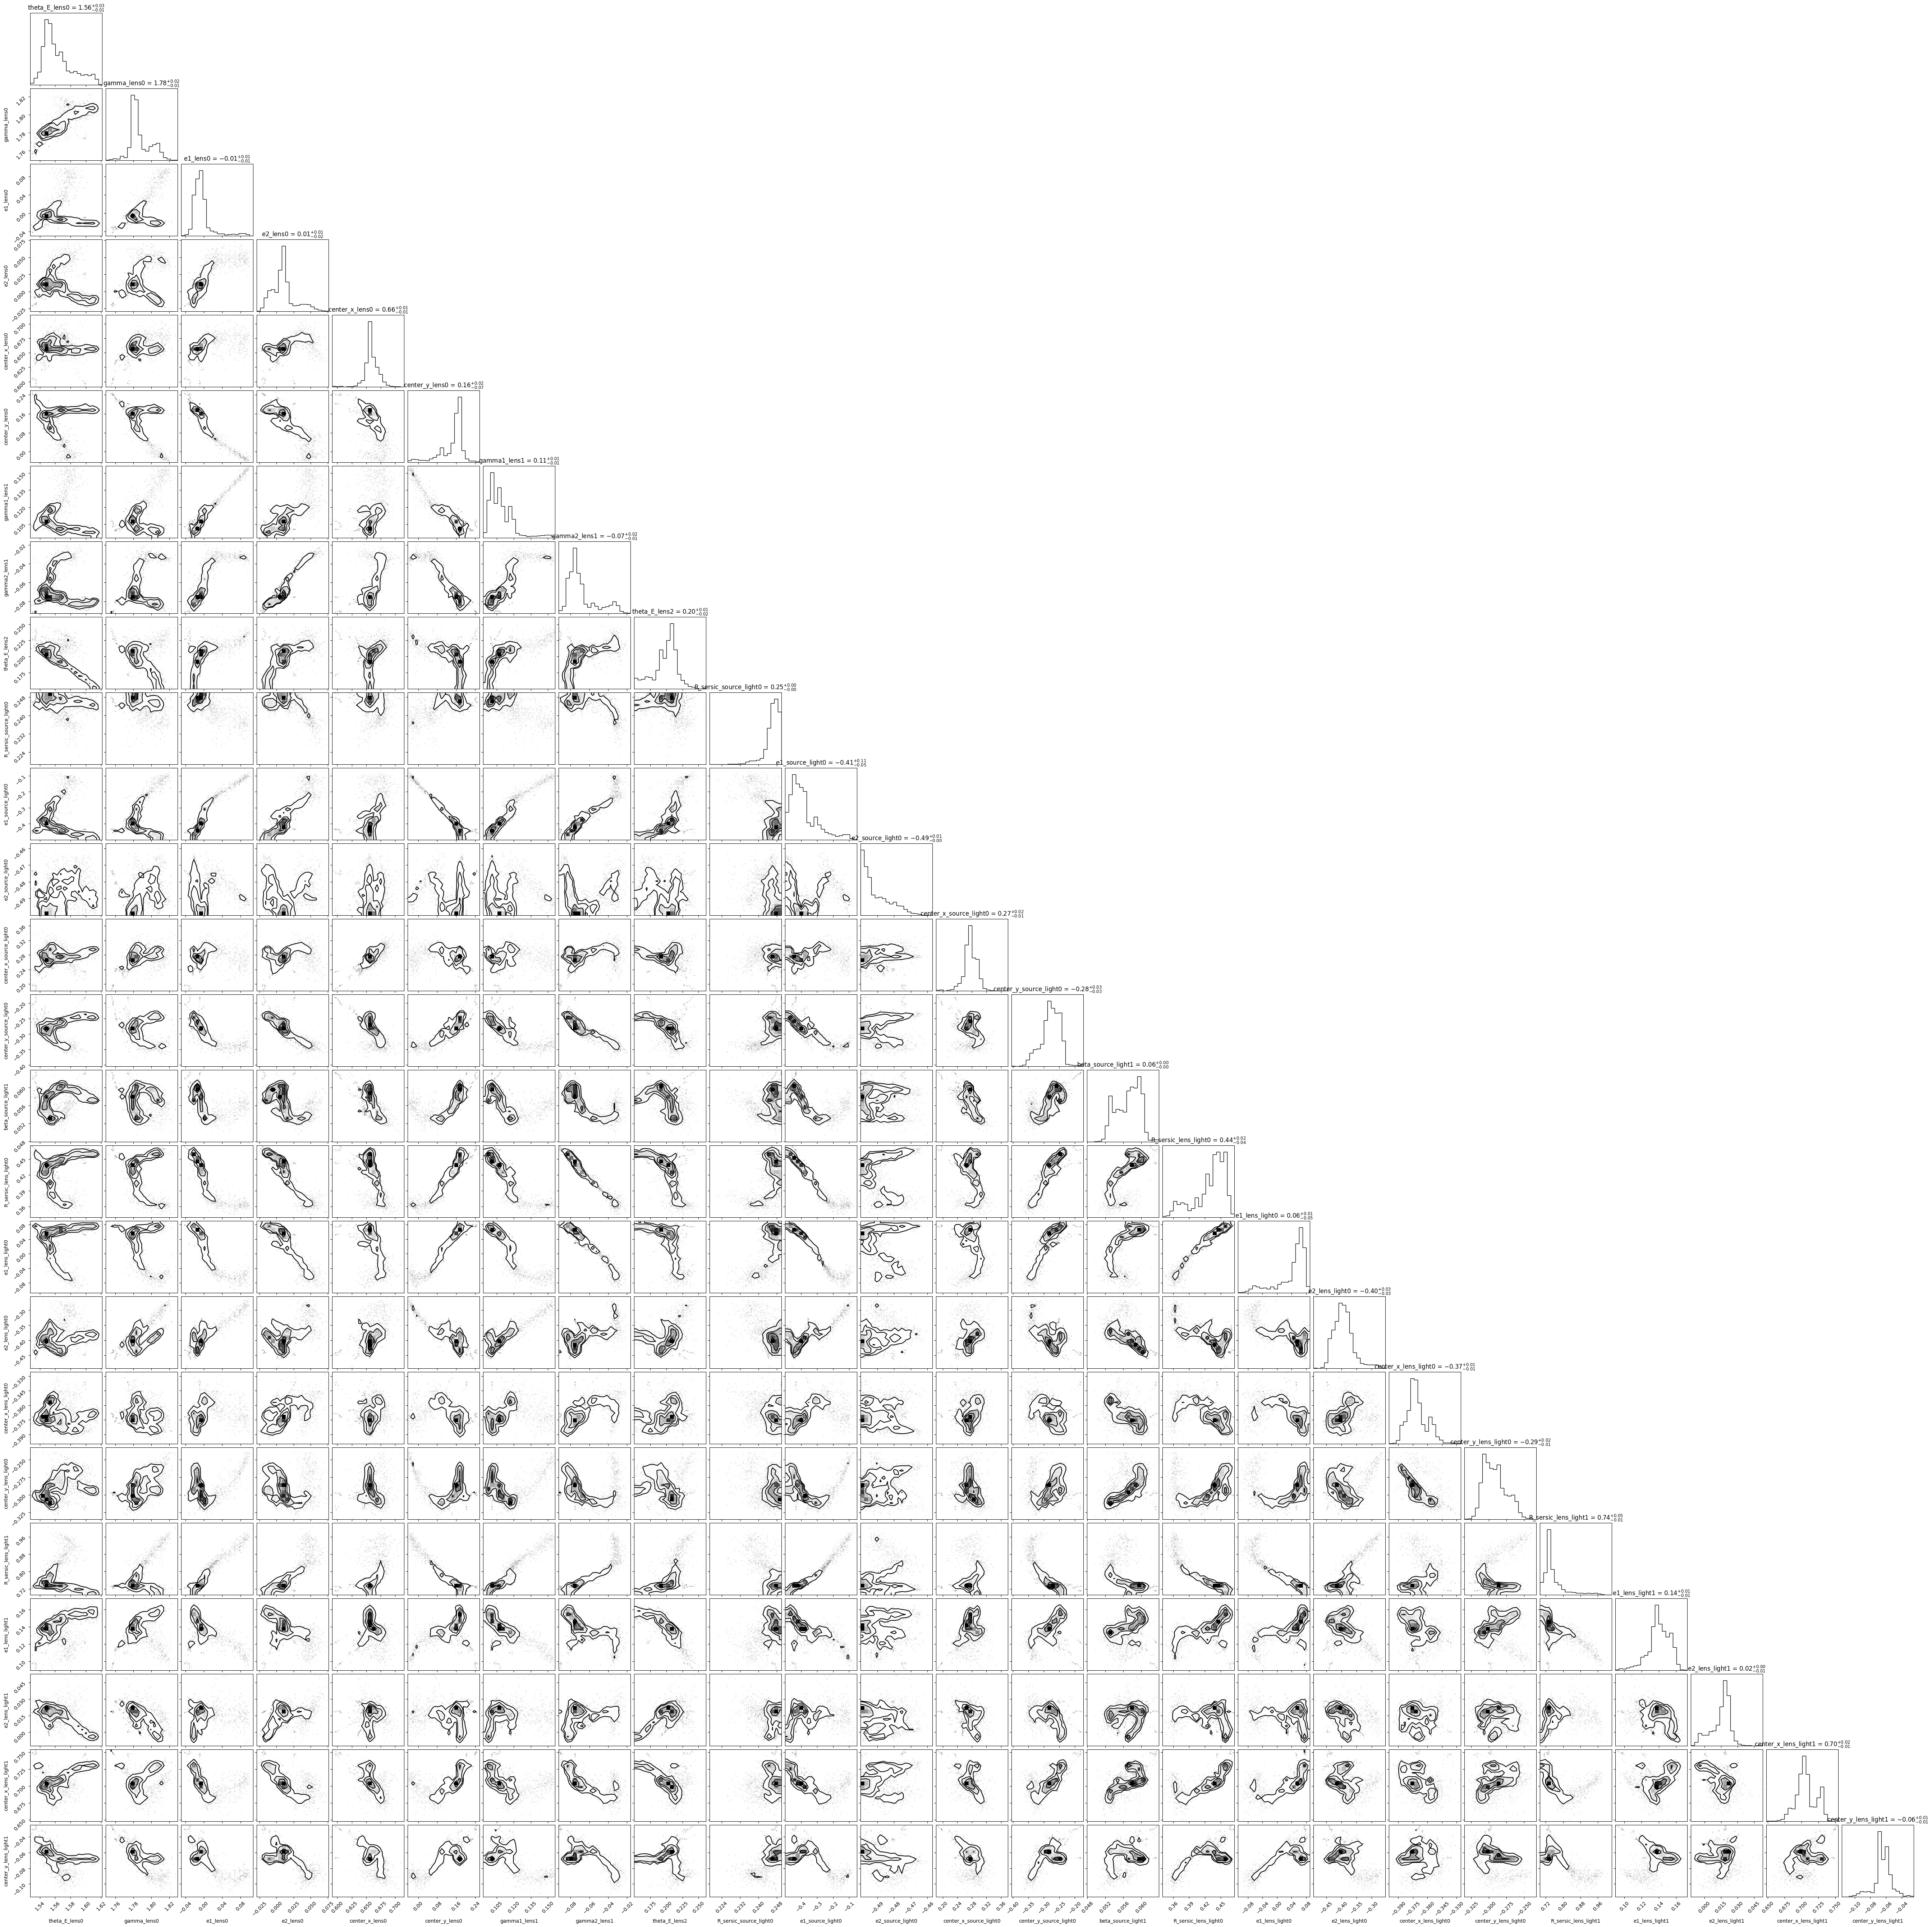

In [ ]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 600
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        #if not samples_mcmc_cut == []:
        n, num_param = np.shape(samples_mcmc_cut)
        print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
        plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

-6.254562167726388 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  6.254562167726379


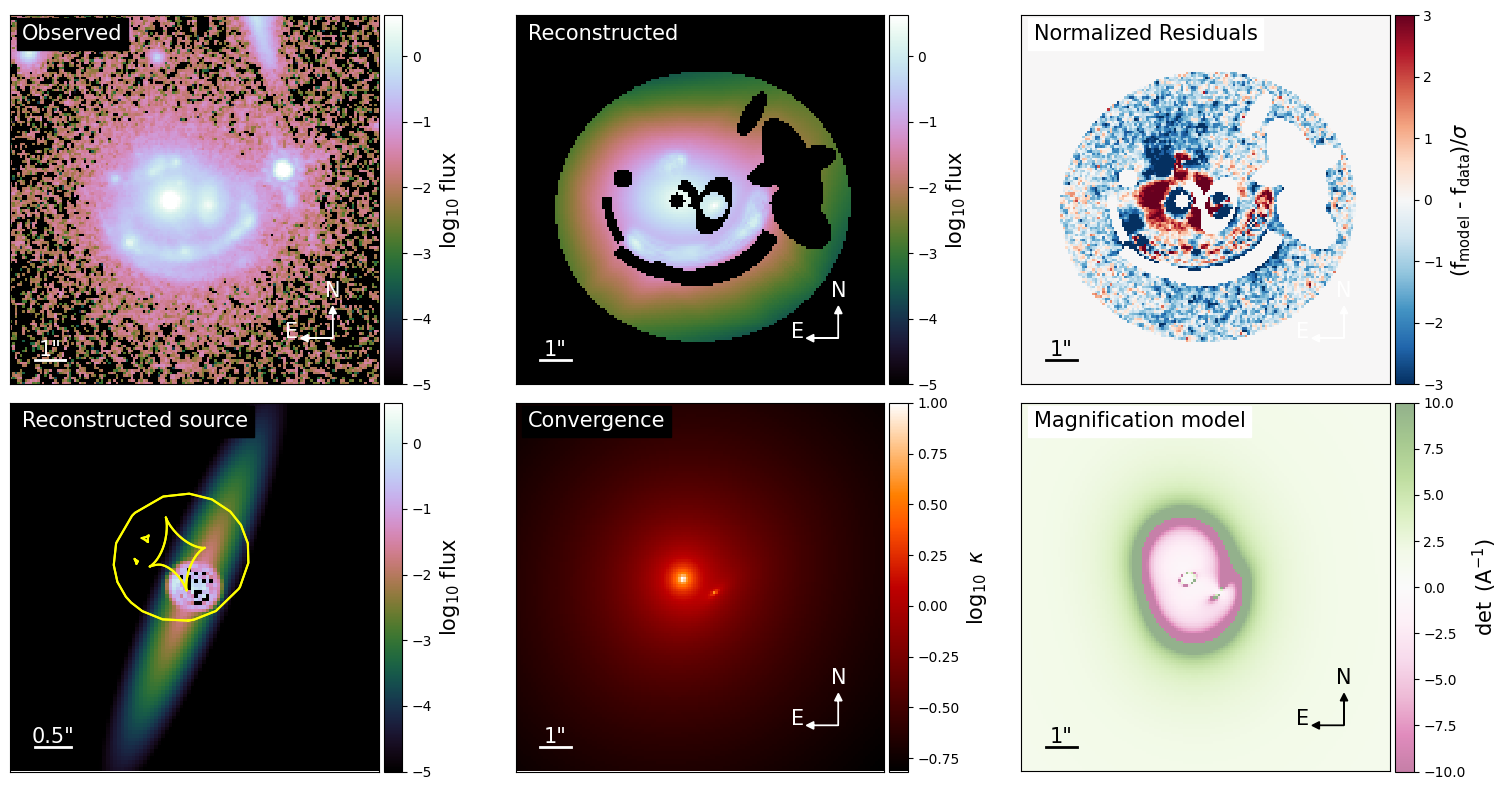

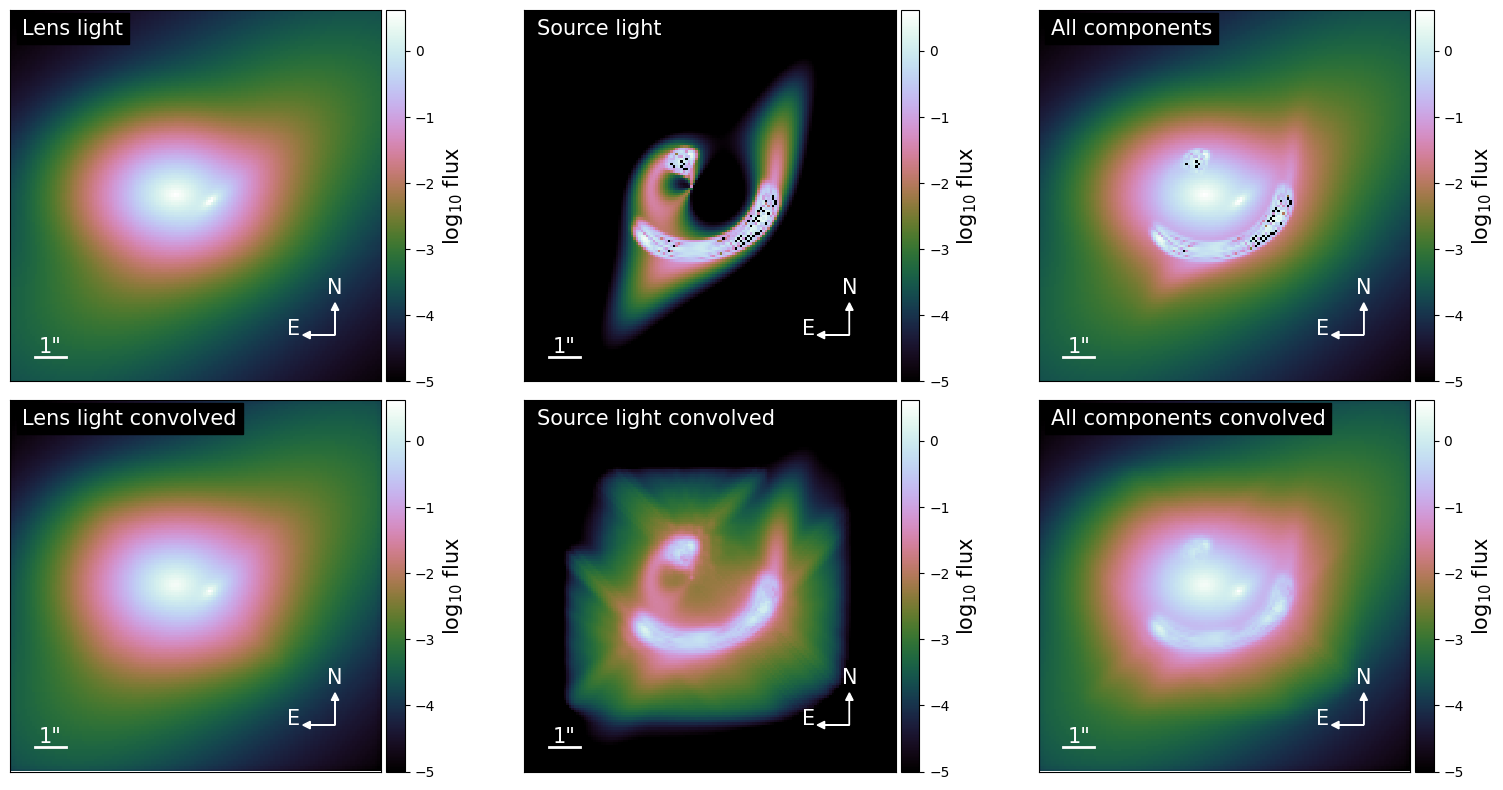

{'kwargs_lens': [{'theta_E': 1.6136721639282658, 'gamma': 1.8075827784486047, 'e1': -0.0214972134615758, 'e2': -0.014553560660417943, 'center_x': 0.6581220872059829, 'center_y': 0.1742805622787085}, {'gamma1': 0.09971338318710454, 'gamma2': -0.08227650292866089, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.15148960913243087, 'e1': 0.09123797793256183, 'e2': -0.37827706034783554, 'center_x': -0.37982164082277037, 'center_y': -0.2826790849865984}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.24747205168439723, 'n_sersic': 1, 'e1': -0.48928733741507663, 'e2': -0.492066576366747, 'center_x': 0.2984012434822463, 'center_y': -0.24410825526861146}, {'amp': 1, 'n_max': 14, 'beta': 0.05670856434078308, 'center_x': 0.2984012434822463, 'center_y': -0.24410825526861146}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.4630101902459683, 'n_sersic': 4.0, 'e1': 0.09123797793256183, 'e2': -0.37827706034783554, 'center_x': -0.37982164082277037, 'center_y': -0.2826790849865984}, {'amp': 1, 'R_sersic': 0.7143917

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result_mcmc)

In [ ]:

multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = 1000  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result_mcmc, multi_band_list_out, kwargs_fixed_out]

output_path = "DESIJ0923+1829_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)



In [ ]:
#import lenstronomy.Util.param_util.el

result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][1]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][1]["e2"]

mass_phi, mass_q = param_util.ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = param_util.ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}".format(
        mass_q,
        light_q,
    )
)

mass_q: 0.9493932000571922,
light_q: 0.7473658939639835
